In [109]:
import xgboost as xgb
from xgboost import XGBRegressor  # For regression tasks
from xgboost import XGBClassifier  # For classification tasks
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

In [110]:
# Load and clean data
df = pd.read_csv("../Resources/cleaned_st_paul_properties.csv")
# df = pd.read_csv("Resources/st_paul_sold_properties .csv")

df.head()

,list_date,list_price,sold_date,sold_price,beds,baths,sqft,lot_sqft,city,street,zip,latitude,longitude
0,1/23/2025,500000.0,2/28/2025,505003,3.0,2.0,1636.0,5009.0,Saint Paul,2098 Pinehurst Ave,55116,44.918628,-93.189055
1,9/3/2024,189900.0,12/11/2024,189900,2.0,1.0,832.0,4792.0,Saint Paul,536 Edmund Ave,55103,44.958192,-93.122838
2,12/20/2024,275000.0,1/10/2025,266800,3.0,1.0,1297.0,6534.0,Saint Paul,967 California Ave W,55117,44.991249,-93.140914
3,12/1/2024,324900.0,1/31/2025,325000,3.0,1.5,2185.0,6055.0,Saint Paul,627-629 Minnehaha Ave E,55130,44.963264,-93.074138
4,11/19/2024,214900.0,1/9/2025,210000,2.0,1.0,926.0,5001.0,Saint Paul,1631 Woodbridge St,55117,44.990397,-93.108765


In [111]:
# Convert dates
df['list_date'] = pd.to_datetime(df['list_date'], errors='coerce')
df['sold_date'] = pd.to_datetime(df['sold_date'], errors='coerce')

# Drop rows with missing or invalid dates
df = df.dropna(subset=['list_date', 'sold_date'])

# Calculate days_on_market
df['days_on_market'] = (df['sold_date'] - df['list_date']).dt.days
df = df[df['days_on_market'] >= 0]
# Calculate price per sq ft, bed/bath ratio
df['price_per_sqft'] = df['list_price'] / df['sqft']
df['beds_baths_ratio'] = df['beds'] / (df['baths'] + 1)
df['month_listed'] = pd.to_datetime(df['list_date'], errors='coerce').dt.month
df['year_listed'] = pd.to_datetime(df['list_date'], errors='coerce').dt.year

# drop duplicate street values
df['street'] = df['street'].str.strip() # Removes white spaces and new lines. 
df.drop_duplicates(subset=['street'], inplace=True) 

# Drop rows with missing target
df = df.dropna(subset=['days_on_market'])

# Drop unneeded columns
df_model = df.drop(columns=['list_date', 'sold_date', 'city', 'street', 'latitude', 'longitude', 'zip', 'list_price', 'sold_price'], errors='ignore')

# Drop rows with any remaining NaNs
df_model = df_model.dropna()
df_model.head()

,beds,baths,sqft,lot_sqft,days_on_market,price_per_sqft,beds_baths_ratio,month_listed,year_listed
0,3.0,2.0,1636.0,5009.0,36,305.623472,1.0,1,2025
1,2.0,1.0,832.0,4792.0,99,228.245192,1.0,9,2024
2,3.0,1.0,1297.0,6534.0,21,212.027756,1.5,12,2024
3,3.0,1.5,2185.0,6055.0,61,148.695652,1.2,12,2024
4,2.0,1.0,926.0,5001.0,51,232.073434,1.0,11,2024


In [112]:
# Features and target
X = df_model.drop(columns='days_on_market')
y = df_model['days_on_market']

# Apply log1p transformation to target
# y_log = np.log1p(y)

In [113]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)



In [114]:
# Ste up the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,  # Number of trees
    learning_rate=0.05,  # Step size for optimization
    max_depth=6,  # Tree depth
    subsample=0.8,  # Fraction of data used per tree
    colsample_bytree=1.0,  # Fraction of features used per tree
    random_state=40
)

# from sklearn.feature_selection import RFE
# # Apply RFE with XGBoost to remove low-value parameters
# xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, subsample=1.0, random_state=42)
# rfe = RFE(xgb_model, n_features_to_select=5, step=1)  # Select top 5 features
# X_train_selected = rfe.fit_transform(X_train, y_train)
# X_test_selected = rfe.transform(X_test)  # Transform test data using the same selection

# Train the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [115]:
# Make predictions and evaluate 
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MAE: 19.82
R²: 0.4904


In [116]:
# # use GridSearchCV to find the optimal parameters 
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# grid_search = GridSearchCV(XGBRegressor(random_state=40), param_grid, cv=5, scoring='r2', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(f"Best Parameters: {grid_search.best_params_}")


In [117]:
# # Re-run the model with the optimized parameters 
# from xgboost import XGBRegressor

# # Initialize XGBoost with optimized hyperparameters
# xgb_model = XGBRegressor(
#     learning_rate=0.05,  
#     max_depth=9,  
#     n_estimators=500,  
#     subsample=1.0,  
#     colsample_bytree=0.5,  
#     random_state=40
# )

# # Train the model
# xgb_model.fit(X_train, y_train)


In [118]:
# y_pred = xgb_model.predict(X_test)


In [119]:
# from sklearn.metrics import mean_absolute_error, r2_score

# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Optimized Model MAE: {mae:.2f}")
# print(f"Optimized Model R²: {r2:.4f}")


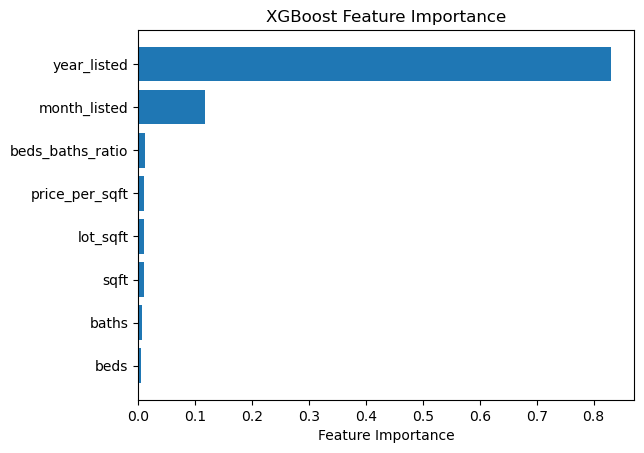

In [120]:
import matplotlib.pyplot as plt
importance = xgb_model.feature_importances_
plt.barh(X_train.columns, importance)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()


In [121]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Define a set of hyperparameter combinations to test
param_grid = [
    {"learning_rate": 0.01, "max_depth": 6, "n_estimators": 300, "subsample": 0.8},
    {"learning_rate": 0.05, "max_depth": 9, "n_estimators": 100, "subsample": 0.6},
    {"learning_rate": 0.1, "max_depth": 5, "n_estimators": 500, "subsample": 1.0},
]

# Track best model
best_r2 = -float("inf")
best_model = None
best_params = None

# Loop through hyperparameter sets
for params in param_grid:
    xgb_model = XGBRegressor(
        colsample_bytree=1.0,
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        n_estimators=params["n_estimators"],
        subsample=params["subsample"],
        random_state=40
    )
    
    # Train model
    xgb_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = xgb_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Params: {params} → R²: {r2:.4f}, MAE: {mae:.2f}")
    
    # Update best model if performance is better
    if r2 > best_r2:
        best_r2 = r2
        best_model = xgb_model
        best_params = params

print(f"\nBest Model Parameters: {best_params} with R²: {best_r2:.4f}")


Params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8} → R²: 0.5510, MAE: 19.11
Params: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.6} → R²: 0.5155, MAE: 19.86
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 1.0} → R²: 0.5278, MAE: 19.66

Best Model Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8} with R²: 0.5510


In [122]:
from xgboost import XGBRegressor

final_xgb_model = XGBRegressor(
    learning_rate=0.01,  
    max_depth=6,  
    n_estimators=300,  
    subsample=0.8,  
    colsample_bytree=1.0,  
    random_state=40
)

# Train the model
final_xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [123]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = final_xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Model MAE: {mae:.2f}")
print(f"Final Model R²: {r2:.4f}")


Final Model MAE: 19.11
Final Model R²: 0.5510
